In [ ]:
#Utility libraries
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
from google.colab.patches import cv2_imshow
import cv2
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# For model building
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from tqdm import tqdm

#Splitting Dataset for Augmentation

In [ ]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = "/content/drive/My Drive/Kaggle/Dataset/train"
classes_dir = ['basketball_court', 'beach', 'forest', 'others', 'railway', 'swimming_pool', 'tennis_court']

val_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'/train/' + cls)
    os.makedirs(root_dir +'/val/' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + "/" + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames= np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val/' + cls)


#Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.3,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='constant')

classes = ['basketball_court', 'beach', 'forest', 'others', 'railway', 'swimming_pool', 'tennis_court']

for cls in classes:
  for filename in tqdm(os.listdir("/content/drive/My Drive/Kaggle/Dataset/train/train/"+cls)):
    img = load_img("/content/drive/My Drive/Kaggle/Dataset/train/train/"+cls+"/"+filename)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/drive/My Drive/Kaggle/Dataset/train_new/train/"+cls, save_prefix=filename, save_format='jpeg'):
        i += 1
        if i > 10:
            break  # otherwise the generator would loop indefinitely

#Data Transformation

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomCrop(224),
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(512,scale=(0.7, 1.0), ratio=(0.75, 1.3333333333333333)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(5, translate=(0.2,0.2), scale=(0.9,1.2), shear=(10,10), resample=False, fillcolor=0),
        transforms.RandomPerspective(distortion_scale=0.1),
        #transforms.RandomRotation(10, resample=False, expand=False),
        #transforms.RandomErasing(p=0.5),
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.3794, 0.3961, 0.3725], [0.1846, 0.1853, 0.1804])
    ]),
    'validation': transforms.Compose([                                    
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3794, 0.3961, 0.3725], [0.1846, 0.1853, 0.1804])
    ]),
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Dataset and Dataloader preparation

In [ ]:
#making the dataset
train_dataset = datasets.ImageFolder("/content/drive/My Drive/Kaggle/Dataset/train_new/train/", data_transforms['train'])
val_dataset = datasets.ImageFolder("/content/drive/My Drive/Kaggle/Dataset/train/val", data_transforms['validation'])


#making the dataloader
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(
                                    train_dataset,                                        
                                    batch_size=32,
                                    shuffle=True, num_workers=4)
dataloaders['validation'] = torch.utils.data.DataLoader(
                                    val_dataset,                                        
                                    batch_size=4,
                                    shuffle=True, num_workers=4)

dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['validation'] = len(val_dataset)
classes = train_dataset.classes

In [ ]:
print(dataset_sizes)

{'train': 4926, 'validation': 112}


#Calculating mean 

In [ ]:
#calculating mean and std for normalizing dataset
#Calculated values are already used in the tranformation
data = next(iter(dataloaders['train']))
data[0].mean(axis = (0, 2, 3)), data[0].std(axis = (0, 2, 3))

#Plotting distribution of normalized training dataset
##We can see that the mean is around 0

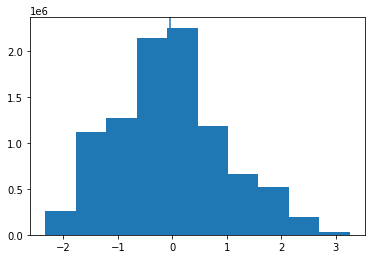

In [ ]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

#Sample training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


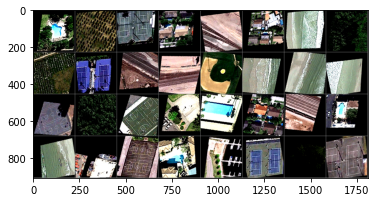

swimming_pool others tennis_court others


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#GNRNet

In [ ]:
class GNRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(64)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer5 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.FC = nn.Sequential(
            nn.Linear(100352, 1000),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 7)
        )
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.ConvLayer5(x)
        x = x.view(x.size(0), -1)
        x = self.FC(x)

       
        #Modified Softmax
        return F.log_softmax(x, dim = 1)

model = GNRNet()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
'''
# separate optimizer for classifier and convolutional blocks  
optimizer_fc = torch.optim.SGD([param for (name, param) in model.named_parameters() if "FC" in name], lr=0.0001, weight_decay=0.05)
optimizer_conv = torch.optim.SGD([param for (name, param) in model.named_parameters() if "FC" not in name], lr=0.001, weight_decay=0.05)

# separate LR_Scheduler for classifier and convolutional blocks
exp_lr_scheduler_fc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fc)
exp_lr_scheduler_conv = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_conv)

#Sanity check of above model

In [ ]:
x = torch.rand([1,3,224,224])
inputt = x.to(device)
outputs = model(inputt)
outputs

tensor([[-1.3739, -2.4743, -2.6088, -1.5881, -2.3353, -2.3220, -1.6614]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [ ]:
model

GNRNet(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3),

#Early-Stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0



#Training Loop

In [ ]:

#added new parameter of start_epoch
def train_model(model, criterion, optimizer_fc, optimizer_conv, scheduler_fc, scheduler_conv, num_epochs=10,resume=None, model_name='GNR'):
    since = time.time()

    train_loss = []
    val_loss = []

    best_acc = 0.0
    start_epoch = 0

    #Definging Early stopping
    #early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(start_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:#
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            ground_truth = []
            predictions = []
            confidence = []

            new_soft = []
            new_live_images = []
            new_ground_truth = []
            new_predictions = []

            
            # Iterate over data.
            temp = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #labels = labels.squeeze(-1)

                #optimizer.zero_grad()
                # zero the parameter gradients
                optimizer_fc.zero_grad()
                optimizer_conv.zero_grad()

                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #optimizer.step()
                        optimizer_fc.step()
                        optimizer_conv.step()

                    else:
                        ground_truth.append(labels)
                        predictions.append(preds)
                        # print(outputs)
                        conf_scores,idx = torch.max(torch.nn.functional.softmax(outputs,dim=1),dim=1)
                        # print(idx)
                        confidence.append(conf_scores)

                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #print("1 Batch done")
                
            if phase == 'validation':
                #scheduler.step(running_loss)
                #scheduler.step()
                scheduler_fc.step(running_loss)
                scheduler_conv.step(running_loss)
                #scheduler_fc.step()
                #scheduler_conv.step()
            if phase == 'validation':

                a,b,c = torch.cat(ground_truth), torch.cat(predictions), torch.cat(confidence)
                a = a.detach().cpu().numpy()
                b = b.detach().cpu().numpy()
                c = c.detach().cpu().numpy()

                a = [0 if x==0 else 1 for x in a]
                b = [0 if x==0 else 1 for x in b]

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
              train_loss.append(epoch_loss)
            elif phase == "test":
              test_loss.append(epoch_loss)
            else:
              val_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

                model_weight_dir = './weights_'+model_name
            '''
            #Early-Stopping
            if phase == "validation":   
              early_stopping(epoch_loss, model)
          
              if early_stopping.early_stop:
                print("Early stopping")
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                return model, train_loss, val_loss
            '''

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, train_loss, val_loss

In [ ]:
model_training = train_model(model, criterion, 
                              optimizer_fc, optimizer_conv, 
                              exp_lr_scheduler_fc, exp_lr_scheduler_conv,
                              num_epochs=100)

Epoch 0/99
----------
train Loss: 1.8301 Acc: 0.2925
validation Loss: 1.9180 Acc: 0.1364

Epoch 1/99
----------
train Loss: 1.3805 Acc: 0.5545
validation Loss: 1.5489 Acc: 0.5227

Epoch 2/99
----------
train Loss: 1.1564 Acc: 0.6214
validation Loss: 1.0849 Acc: 0.7348

Epoch 3/99
----------
train Loss: 1.0293 Acc: 0.6577
validation Loss: 0.8963 Acc: 0.7576

Epoch 4/99
----------
train Loss: 0.9417 Acc: 0.6902
validation Loss: 0.7882 Acc: 0.7652

Epoch 5/99
----------
train Loss: 0.8365 Acc: 0.7419
validation Loss: 0.7278 Acc: 0.7879

Epoch 6/99
----------
train Loss: 0.7634 Acc: 0.7495
validation Loss: 0.6742 Acc: 0.8030

Epoch 7/99
----------
train Loss: 0.7329 Acc: 0.7514
validation Loss: 0.6187 Acc: 0.8182

Epoch 8/99
----------
train Loss: 0.6576 Acc: 0.8107
validation Loss: 0.5897 Acc: 0.8409

Epoch 9/99
----------
train Loss: 0.6695 Acc: 0.8031
validation Loss: 0.5558 Acc: 0.8409

Epoch 10/99
----------
train Loss: 0.6097 Acc: 0.8069
validation Loss: 0.5225 Acc: 0.8409

Epoch 11/

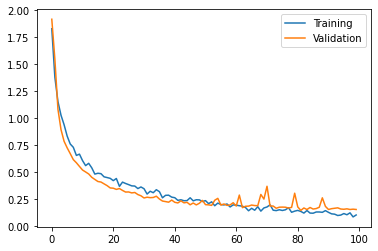

In [ ]:
import matplotlib.patches as mpatches
plt.plot(model_training[1], label="Training")
plt.plot(model_training[2], label="Validation")
#training = mpatches.Patch(color='skyblue', label='Training')
#validation = mpatches.Patch(color='orange', label='validation')
plt.legend()

#Saving the model

In [ ]:
#torch.save(model.state_dict(), "/content/drive/My Drive/Kaggle/GNRNet_5.pth")
#torch.save(model.state_dict(), "/content/drive/My Drive/Kaggle/GNRNet_5.pt")

#Testing before submission
### As there are marks for number of submission I made testing dataset by manually labelling the images since the number of images were less and then testing my final model on it

In [ ]:
test_dataset = datasets.ImageFolder("/content/drive/My Drive/Kaggle/Dataset/Labeled_test_set", data_transforms['validation'])

test_dataloader = torch.utils.data.DataLoader(
                                    test_dataset,                                        
                                    batch_size=1,
                                    shuffle=False, num_workers=4)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        #data = data.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 95 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 95/95 [00:10<00:00,  9.25it/s]

Accuracy of the network on the 95 test images: 94 %


#Sanity Check for CSV file creation

In [ ]:
data = pd.DataFrame(columns=["ImageID", "Label"])
data = data.append({"ImageID": int(filename[:4]),
                      "Label": pred_label}, ignore_index=True)

In [ ]:
classes[outputs.index(max(outputs))]

'tennis_court'

In [ ]:
classes

['basketball_court',
 'beach',
 'forest',
 'others',
 'railway',
 'swimming_pool',
 'tennis_court']

#Final CSV file creation

In [ ]:
import pandas as pd
import os
from PIL import Image


data = pd.DataFrame(columns=["ImageID", "Label"])
for filename in tqdm(os.listdir("/content/drive/My Drive/Kaggle/Dataset/test_set")):
  img = Image.open("/content/drive/My Drive/Kaggle/Dataset/test_set/"+filename)
  img = data_transforms['validation'](img)
  img = torch.reshape(img, (1, 3, 224, 224))
  input_img = img.to(device)
  outputs = model(input_img)
  outputs = outputs.cpu()
  outputs = list(outputs[0].detach().numpy())
  pred_class = classes[outputs.index(max(outputs))]
  if pred_class =='basketball_court':
    pred_label = 1
  elif pred_class == 'beach':
    pred_label = 2
  elif pred_class == 'forest':
    pred_label = 3
  elif pred_class == 'railway':
    pred_label = 4
  elif pred_class == 'tennis_court':
    pred_label = 5
  elif pred_class == 'swimming_pool':
    pred_label = 6
  elif pred_class == 'others':
    pred_label = 7
  
  data = data.append({"ImageID": int(filename[:4]),
                      "Label": pred_label}, ignore_index=True)


100%|██████████| 95/95 [01:08<00:00,  1.39it/s]


In [ ]:
data = data.sort_values(by='ImageID', ascending=1)
data.to_csv("new_94.csv", index=False)